# <center>**Chess game analysis**</center>
<center>Data analytics 2022</center>
<center>Made by: Barbara Wąsik, Aneta Walas</center>

**Data**

In the project we used data which contains over 20 000 chess games (exactly 20 058 games). The set of data was collected from played games on site Lichess.org. The data set was downloaded from Kaggle.com. 
The data set contains for each played game:
- Game ID;
- Rated (T/F);
- Start Time;
- End Time;
- Number of Turns;
- Game Status;
- Winner;
- Time Increment;
- White Player ID;
- White Player Rating;
- Black Player ID;
- Black Player Rating;
- All Moves in Standard Chess Notation;
- Opening Eco (Standardised Code for any given opening, list here);
- Opening Name;
- Opening Ply (Number of moves in the opening phase)

**Problem formualiton**

The problem analyzed in the project focuses on the probability of winning chess game based on the openings used in a game and the color of the winning pawn (black or white). In the dataset considered, there are more than 300 different openings used by players. The main purpose of the project was to predict the probability of winning the game taking into consideration opennings used.


**Data preparation**

Import of the necessary libraries.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az
import numpy as np
import math
import scipy.stats as stats
from cmdstanpy import CmdStanModel

Read the data about the games/matches from external file.

In [13]:
file = 'D:\\Studia\\Nowyprojekt_DA\\games.csv'
games = pd.read_csv(file)
games.head()

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply
0,TZJHLljE,False,1.504210e+12,1.504210e+12,13,outoftime,white,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5
1,l1NXvwaE,True,1.504130e+12,1.504130e+12,16,resign,black,5+10,a-00,1322,skinnerua,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4
2,mIICvQHh,True,1.504130e+12,1.504130e+12,61,mate,white,5+10,ischia,1496,a-00,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,3
3,kWKvrqYL,True,1.504110e+12,1.504110e+12,61,mate,white,20+0,daniamurashov,1439,adivanov2009,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,D02,Queen's Pawn Game: Zukertort Variation,3
4,9tXo1AUZ,True,1.504030e+12,1.504030e+12,95,mate,white,30+3,nik221107,1523,adivanov2009,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,C41,Philidor Defense,5


In [12]:
print(games['victory_status'].unique())

['outoftime' 'resign' 'mate' 'draw']


**Data tidying**

The games in which 'draw' was result of game were removed. Only black and white winner remains.

In [14]:
games.drop(games[games['winner'] == 'draw'].index, inplace = True)

In order to use data in convenient way, we applied mapping of the opening code names to numbers. 

The ECO Codes is a classification system for the chess openings moves. So each ECO Code is mapped to number. In the example below we can see what under the column opening_eco each unique openning has mapped a number from 1 to 365.

In [15]:
l = games['opening_eco'].unique()
val = {}
for x in range(len(games['opening_eco'].unique())):
    val[l[x]] = x+1


games['opening_eco'] = games['opening_eco'].map(val)
opening_e = games[['opening_eco']]

games.head()

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply
0,TZJHLljE,False,1.504210e+12,1.504210e+12,13,outoftime,white,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,1,Slav Defense: Exchange Variation,5
1,l1NXvwaE,True,1.504130e+12,1.504130e+12,16,resign,black,5+10,a-00,1322,skinnerua,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,2,Nimzowitsch Defense: Kennedy Variation,4
2,mIICvQHh,True,1.504130e+12,1.504130e+12,61,mate,white,5+10,ischia,1496,a-00,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,3,King's Pawn Game: Leonardis Variation,3
3,kWKvrqYL,True,1.504110e+12,1.504110e+12,61,mate,white,20+0,daniamurashov,1439,adivanov2009,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,4,Queen's Pawn Game: Zukertort Variation,3
4,9tXo1AUZ,True,1.504030e+12,1.504030e+12,95,mate,white,30+3,nik221107,1523,adivanov2009,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,5,Philidor Defense,5


We assumed in this project that victory is only acomplished if player wins with mate. So we change column with victory status that 1 corresponds to game win by mate and in other cases game is lost so it coresponds to 0. 

In [16]:
for indx, victory in enumerate(games['victory_status']):
    if(victory == 'mate'):
        games['victory_status'][indx] = 1
    else:
        games['victory_status'][indx] = 0

games.head()


C:\Users\Huawei\AppData\Local\Temp/ipykernel_12944/860546557.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  games['victory_status'][indx] = 0
C:\Users\Huawei\AppData\Local\Temp/ipykernel_12944/860546557.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  games['victory_status'][indx] = 1


,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply
0,TZJHLljE,False,1.504210e+12,1.504210e+12,13,0,white,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,1,Slav Defense: Exchange Variation,5
1,l1NXvwaE,True,1.504130e+12,1.504130e+12,16,0,black,5+10,a-00,1322,skinnerua,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,2,Nimzowitsch Defense: Kennedy Variation,4
2,mIICvQHh,True,1.504130e+12,1.504130e+12,61,1,white,5+10,ischia,1496,a-00,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,3,King's Pawn Game: Leonardis Variation,3
3,kWKvrqYL,True,1.504110e+12,1.504110e+12,61,1,white,20+0,daniamurashov,1439,adivanov2009,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,4,Queen's Pawn Game: Zukertort Variation,3
4,9tXo1AUZ,True,1.504030e+12,1.504030e+12,95,1,white,30+3,nik221107,1523,adivanov2009,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,5,Philidor Defense,5


Mapping black and white pawns to 1 (black) and 2 (white). 

In [17]:
for indx, pawn in enumerate(games['winner']):
    if(pawn == 'white'):
        games['winner'][indx] = 2
    else:
        games['winner'][indx] = 1

games.head()

C:\Users\Huawei\AppData\Local\Temp/ipykernel_12944/851068845.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  games['winner'][indx] = 2
C:\Users\Huawei\AppData\Local\Temp/ipykernel_12944/851068845.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  games['winner'][indx] = 1


,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply
0,TZJHLljE,False,1.504210e+12,1.504210e+12,13,0,2,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,1,Slav Defense: Exchange Variation,5
1,l1NXvwaE,True,1.504130e+12,1.504130e+12,16,0,1,5+10,a-00,1322,skinnerua,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,2,Nimzowitsch Defense: Kennedy Variation,4
2,mIICvQHh,True,1.504130e+12,1.504130e+12,61,1,2,5+10,ischia,1496,a-00,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,3,King's Pawn Game: Leonardis Variation,3
3,kWKvrqYL,True,1.504110e+12,1.504110e+12,61,1,2,20+0,daniamurashov,1439,adivanov2009,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,4,Queen's Pawn Game: Zukertort Variation,3
4,9tXo1AUZ,True,1.504030e+12,1.504030e+12,95,1,2,30+3,nik221107,1523,adivanov2009,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,5,Philidor Defense,5


**Final dataset used in calculations**

We decided to use smaller data set because data set which contains over 20 000 games takes too much time in computations. We trimmed our data set to 10 000 games.

In [18]:
games_data_set = games[['id','victory_status','winner','opening_eco']]
games_data_set = games_data_set[:10000]
games_data_set.head()

,id,victory_status,winner,opening_eco
0,TZJHLljE,0,2,1
1,l1NXvwaE,0,1,2
2,mIICvQHh,1,2,3
3,kWKvrqYL,1,2,4
4,9tXo1AUZ,1,2,5


In [19]:
y = games_data_set['victory_status'].values.tolist()
y = list(map(int, y))

In [20]:
P = games_data_set['winner'].values.tolist()
P = list(map(int, P))

**Plots for 10 000 games**

Below there is histograms of victory status and openings used in games 

Text(0.5, 1.0, 'Victory status')

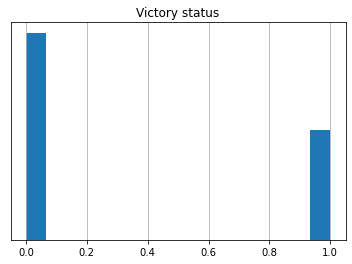

In [21]:
games_data_set['victory_status'].hist(bins = 'auto')
plt.yticks([])
plt.title('Victory status')

Text(0.5, 1.0, 'Openings used in games- codes')

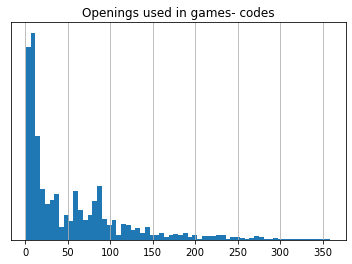

In [22]:
opening_e.hist(bins='auto')
plt.yticks([])
plt.title('Openings used in games- codes')

Text(0.5, 1.0, 'Win - color of the pawns')

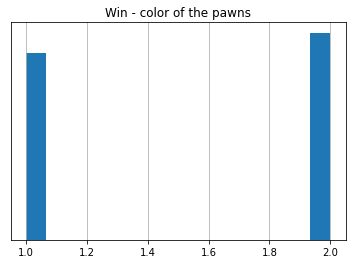

In [23]:
games_data_set['winner'].hist(bins='auto')
plt.yticks([])
plt.title('Win - color of the pawns')

**Plots for whole data set**

# <center>**Model 1**</center>


 The first model consists of parameter alpha. Alpha is a vector which depends on type of openning. 

In the first model we decided to use Bernoulli distribution to determine whether speciffic game will end up with victory based on the oppening used (in the first model) and on color of winning pawn (in the second model additional). Parameter theta is shown below and it takes one argument alpha.
\begin{gather*}
y \sim\ Bernoulli(\theta_i) \\
logit (\theta_i) = \alpha {[oppening]}\\
\alpha  \sim\ N(0,1)
\end{gather*}

**Prior prediction**

For prior predictive distribution was created the model that can be found in the file _prior_1.stan_. The data section has parameter G, which describes number of games played and parameter N which represents used type of opennings. Alpha parameter is described as above, the same applies to theta parameter. 


In [15]:
with open('D:\\Studia\\Nowyprojekt_DA\\prior_1.stan', 'r') as file:
    print(file.read())

data {
  int G; //number of games
  int <lower = 1, upper = 365> N[G]; //opening
}

generated quantities {
  vector[365] alpha;
  int y[G];

  for (k in 1:365) {
    alpha[k] = normal_rng(0,0.5);
  }

  for (k in 1:G) {
    y[k] = bernoulli_rng(inv_logit(alpha[N[k]]));
  }
}


In [16]:
model1_prior = CmdStanModel(stan_file='D:\\Studia\\Nowyprojekt_DA\\prior_1.stan')

data1_prior = {'G' : len(games_data_set), 'N' : games_data_set['opening_eco'].values}

samples1_prior = model1_prior.sample(data=data1_prior,
                        fixed_param=True, 
                        iter_sampling=1000, 
                        iter_warmup=0, 
                        chains=1, 
                        refresh=1000,
                        seed=29042020)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
chain 1 |██████████| 00:07 Sampling completed                      


INFO:cmdstanpy:CmdStan done processing.


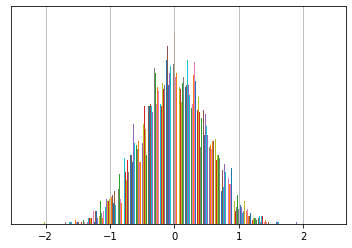

In [24]:
alpha1_prior =samples1_prior.stan_variable('alpha')
plt.hist(alpha1_prior,bins=50)
plt.yticks([])
plt.grid()
plt.show()

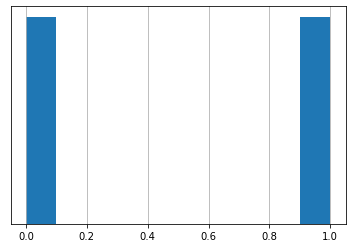

In [25]:
y_sim1_prior =samples1_prior.stan_variable('y')
plt.hist(y_sim1_prior.flatten(),bins=10)
plt.yticks([])
plt.grid()
plt.show()

**Posterior analysis**


In [19]:
model1_post = CmdStanModel(stan_file='D:\\Studia\\Nowyprojekt_DA\\model1.stan')
data1_post = {'G' : len(games_data_set), 'N' : games_data_set['opening_eco'].values, 'y' : y}

samples1_post =  model1_post.sample(data=data1_post, 
                            fixed_param = False,
                            seed=8052020)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status



chain 1 |▉         | 00:10 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:13 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:17 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:21 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:24 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:28 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:32 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:35 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:39 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:42 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:49 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:56 Iteration: 1100 / 2000 [ 55%]  (Sampling)


cha


INFO:cmdstanpy:CmdStan done processing.


In [20]:
alpha1_post = samples1_post.stan_variable('alpha')
y_sim_post = samples1_post.stan_variable('y_sim')

In [21]:
samples1_post.diagnose()

'Processing csv files: C:\\Users\\HW\\AppData\\Local\\Temp\\tmpboxiliac\\model1-20220714001213_1.csv, C:\\Users\\HW\\AppData\\Local\\Temp\\tmpboxiliac\\model1-20220714001213_2.csv, C:\\Users\\HW\\AppData\\Local\\Temp\\tmpboxiliac\\model1-20220714001213_3.csv, C:\\Users\\HW\\AppData\\Local\\Temp\\tmpboxiliac\\model1-20220714001213_4.csv\n\nChecking sampler transitions treedepth.\nTreedepth satisfactory for all transitions.\n\nChecking sampler transitions for divergences.\nNo divergent transitions found.\n\nChecking E-BFMI - sampler transitions HMC potential energy.\nE-BFMI satisfactory.\n\nEffective sample size satisfactory.\n\nSplit R-hat values satisfactory all parameters.\n\nProcessing complete, no problems detected.\n'

In [22]:
samples1_post.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,-6600.00,0.38000,13.000,-6600.00,-6600.00,-6600.00,1300.0,4.3,1.0
alpha[1],-0.29,0.00270,0.270,-0.74,-0.29,0.15,9745.0,33.0,1.0
alpha[2],-0.52,0.00100,0.110,-0.70,-0.52,-0.35,10855.0,37.0,1.0
alpha[3],-0.71,0.00100,0.110,-0.88,-0.70,-0.53,11132.0,38.0,1.0
alpha[4],-0.62,0.00120,0.140,-0.85,-0.62,-0.40,12309.0,42.0,1.0
...,...,...,...,...,...,...,...,...,...
log_lik[9996],-1.10,0.00061,0.060,-1.20,-1.10,-0.98,9606.0,33.0,1.0
log_lik[9997],-1.00,0.00099,0.100,-1.20,-1.00,-0.86,11078.0,38.0,1.0
log_lik[9998],-1.10,0.00073,0.078,-1.20,-1.10,-0.93,11352.0,39.0,1.0


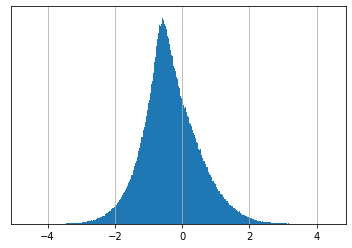

In [23]:
plt.hist(alpha1_post.flatten(),bins='auto')
plt.yticks([])
plt.grid()

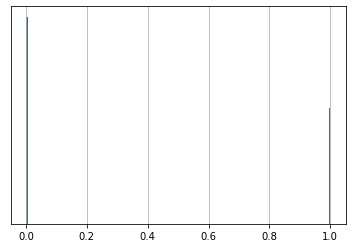

In [26]:
plt.hist(y_sim_post.flatten(),bins='auto')
plt.yticks([])
plt.grid()

# <center>**Model 2**</center>

The second model consists of parameters alpha and beta. Alpha is a vector which depends on type of openning and beta is a vector which depends on color of winning pawn.

In the second model we decided also to use Bernoulli distribution. Parameter theta is shown below and it takes two arguments alpha and beta.

\begin{gather*}
y \sim\ Bernoulli(\theta_i) \\
logit (\theta_i) = \alpha {[oppening]} + \beta {[colorwinning]}\\
\alpha  \sim\ N(0,1)
\end{gather*}

**Prior**

In [27]:
with open('D:\\Studia\\Nowyprojekt_DA\\prior_2.stan', 'r') as file:
    print(file.read())

data {
  int G; //number of games
  int <lower = 1, upper = 365> N[G]; //opening
  int P[G]; // winner pawn
}

generated quantities {
  vector[365] alpha;
  vector[2] beta;
  int y[G];

  for (k in 1:365) {
    alpha[k] = normal_rng(0,1);
  }

  for (i in 1:2) {
    beta[i] = normal_rng(0,1);
  }

  for (k in 1:G) {
    y[k] = bernoulli_rng(inv_logit(alpha[N[k]] + beta[P[k]]));
  }
}


In [28]:
model2_prior = CmdStanModel(stan_file='D:\\Studia\\Nowyprojekt_DA\\prior_2.stan')

data2_prior = {'G' : len(games_data_set), 'N' : games_data_set['opening_eco'].values, 'P' : P}

samples2_prior = model2_prior.sample(data=data2_prior,
                        fixed_param=True, 
                        iter_sampling=1000, 
                        iter_warmup=0, 
                        chains=1, 
                        refresh=1000,
                        seed=29042020)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
chain 1 |██████████| 00:07 Sampling completed                      


INFO:cmdstanpy:CmdStan done processing.


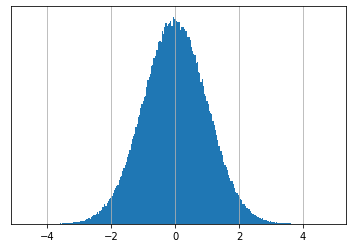

In [29]:
alpha_sim2_prior =samples2_prior.stan_variable('alpha')
plt.hist(alpha_sim2_prior.flatten(),bins='auto')
plt.yticks([])
plt.grid()
plt.show()

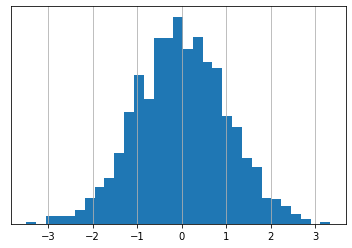

In [30]:
beta_sim2_prior =samples2_prior.stan_variable('beta')
plt.hist(beta_sim2_prior.flatten(),bins='auto')
plt.yticks([])
plt.grid()
plt.show()

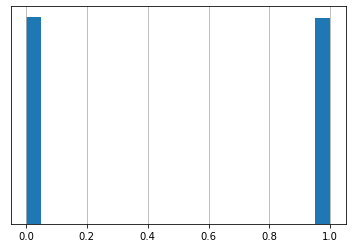

In [31]:
y_sim2_prior =samples2_prior.stan_variable('y')
plt.hist(y_sim2_prior.flatten(),bins=20)
plt.yticks([])
plt.grid()
plt.show()

**Posterior**

In [32]:
with open('D:\\Studia\\Nowyprojekt_DA\\model_2.stan', 'r') as file:
    print(file.read())

data {
  int G; //number of games
  int <lower = 1, upper = 365> N[G]; //openning
  int P[G]; // winner pawn
  int y[G]; 
}
parameters {
  vector[365] alpha;
  vector<lower=0>[2] beta;
}

transformed parameters {
  array [G] real theta;
  for (k in 1:G) {
    theta[k] = inv_logit(alpha[N[k]] + beta[P[k]]);
  }
}

model {
  alpha ~ normal(0,1);
  beta ~ normal(0,1);
  for (k in 1:G) {
    y[k] ~ bernoulli(theta[k]);
  }
}

generated quantities {
  vector[G] y_sim;
  vector[G] log_lik;
  for (k in 1:G) {
    log_lik[k]= bernoulli_lpmf(y[k] | theta[k]);
    y_sim[k] = bernoulli_rng(theta[k]);
  }
}


In [33]:
model2_post = CmdStanModel(stan_file='D:\\Studia\\Nowyprojekt_DA\\model_2.stan')
data2_post = {'G' : len(games_data_set), 'N' : games_data_set['opening_eco'].values, 'P':P, 'y' : y}

samples2_post =  model2_post.sample(data=data2_post, 
                            fixed_param = False,
                            seed=8052020)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status





chain 1 |▉         | 00:19 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:27 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:32 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:38 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:44 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:50 Iteration:  500 / 2000 [ 25%]  (Warmup)
chain 1 |███▋      | 00:56 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 01:03 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 01:09 Iteration:  800 / 2000 [ 40%]  (Warmup)




chain 1 |█████▍    | 01:16 Iteration: 1000 / 2000 [ 50%]  (Warmup)


chain 1 |█████▉    | 01:26 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 01:34 Iteration: 1100 / 2000 [ 55%]  (Sampling)
cha


INFO:cmdstanpy:CmdStan done processing.


In [34]:
alpha2_post = samples2_post.stan_variable('alpha')
beta2_post = samples2_post.stan_variable('beta')
y_sim_post2 = samples2_post.stan_variable('y_sim')

In [39]:
samples2_post.diagnose()

'Processing csv files: C:\\Users\\HW\\AppData\\Local\\Temp\\tmpboxiliac\\model_2-20220714003552_1.csv, C:\\Users\\HW\\AppData\\Local\\Temp\\tmpboxiliac\\model_2-20220714003552_2.csv, C:\\Users\\HW\\AppData\\Local\\Temp\\tmpboxiliac\\model_2-20220714003552_3.csv, C:\\Users\\HW\\AppData\\Local\\Temp\\tmpboxiliac\\model_2-20220714003552_4.csv\n\nChecking sampler transitions treedepth.\nTreedepth satisfactory for all transitions.\n\nChecking sampler transitions for divergences.\nNo divergent transitions found.\n\nChecking E-BFMI - sampler transitions HMC potential energy.\nE-BFMI satisfactory.\n\nEffective sample size satisfactory.\n\nSplit R-hat values satisfactory all parameters.\n\nProcessing complete, no problems detected.\n'

In [40]:
samples2_post.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,-6600.00,0.35000,13.000,-6600.00,-6600.00,-6600.00,1500.0,2.4,1.0
alpha[1],-0.31,0.00300,0.270,-0.75,-0.30,0.13,8052.0,13.0,1.0
alpha[2],-0.54,0.00120,0.110,-0.71,-0.54,-0.36,7571.0,12.0,1.0
alpha[3],-0.72,0.00130,0.110,-0.90,-0.72,-0.54,7110.0,12.0,1.0
alpha[4],-0.64,0.00160,0.140,-0.87,-0.64,-0.41,7956.0,13.0,1.0
...,...,...,...,...,...,...,...,...,...
log_lik[9996],-1.10,0.00069,0.060,-1.20,-1.10,-0.98,7568.0,12.0,1.0
log_lik[9997],-1.00,0.00110,0.110,-1.20,-1.00,-0.85,9832.0,16.0,1.0
log_lik[9998],-1.10,0.00091,0.077,-1.20,-1.10,-0.94,7178.0,12.0,1.0


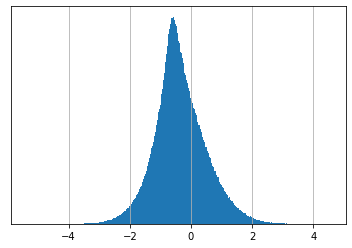

In [35]:
plt.hist(alpha2_post.flatten(),bins='auto')
plt.yticks([])
plt.grid()

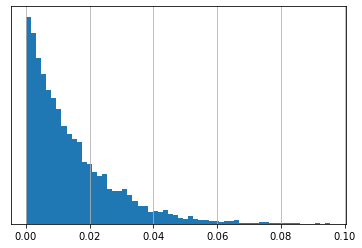

In [36]:
plt.hist(beta2_post.flatten(),bins='auto')
plt.yticks([])
plt.grid()

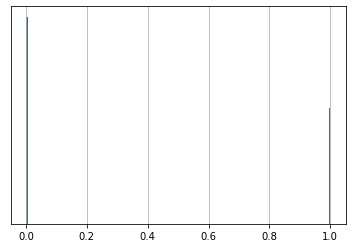

In [37]:
plt.hist(y_sim_post2.flatten(),bins='auto')
plt.yticks([])
plt.grid()

# <center>**Model Comparision**</center>

**Loo and waic comparision of 2 models for white pawns**

In [115]:
arviz_model_1 = az.from_cmdstanpy(
    posterior=samples1_post,
    posterior_predictive="y_sim",
    log_likelihood="log_lik",
)

In [116]:

arviz_model_2 = az.from_cmdstanpy(
    posterior=samples2_post,
    posterior_predictive="y_sim",
    log_likelihood="log_lik",
)

In [117]:
compare_dict_white = {'model1' : arviz_model_1, 'model2' : arviz_model_2}

In [118]:
loo_comp = az.compare(compare_dict_white, ic = 'loo')
loo_comp

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
model1,0,-6526.891556,179.642737,0.000000,0.625772,30.460289,0.000000,False,log
model2,1,-6526.907917,179.294975,0.016361,0.374228,30.417916,0.360436,False,log


<AxesSubplot:xlabel='Log'>

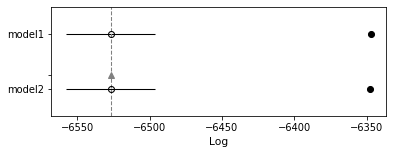

In [119]:
az.plot_compare(loo_comp)

In [120]:
waic_comp = az.compare(compare_dict_white, ic = 'waic')
waic_comp

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
model2,0,-6525.659351,178.046409,0.000000,0.704978,30.411540,0.000000,False,log
model1,1,-6525.684815,178.435996,0.025464,0.295022,30.454384,0.352568,False,log


<AxesSubplot:xlabel='Log'>

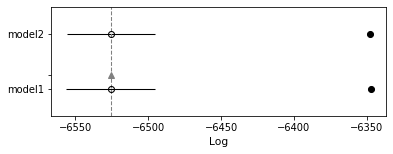

In [121]:
az.plot_compare(waic_comp)

**Conclusion**

Based on the loo comparison the rank of the model 1 is lower. Also the value of loo is higher for the first model, this indicates that it better fits the data. But for waic comparison the situation is opposite - rank of the model 2 is lower and waic information criterion is higher. For loo and waic comaparison both models have value of warnings equals to false. 

Both models indicates that in most cases the game will not be win by mate, which coresponds with the data (in the most cases games are lost). 

